In [1]:
from rsplib import RSPEngine, RSPPublisher, Stream, rdf_table,load_graph, accessURL, Task, URIRef

In [2]:
jasper = RSPEngine("http://jasper:8181/jasper")

In [3]:
jasper.service()

In [4]:
jasper.streams()

[http://redstream:1255/red, http://jasper:8181/jasper/streams/redcount]

In [5]:
jasper.tasks()[0].stream()

In [7]:
qid  = "redcount"
tbox = "http://mynotebook:8888/files/colors.owl"
frmt = "JSON"
body ="""
        SELECT (COUNT(?r) as ?numRed)
        FROM NAMED WINDOW <rw> ON <http://redstream:1255/red> [RANGE PT15S STEP PT5S]
        WHERE {
                WINDOW ?rw { ?r a <http://www.streamreasoning.org/ontologies/2018/9/colors#Red> .}
            }
      """

In [9]:
redcount_query = jasper.create(qid, body, tbox, frmt)


In [10]:
redcount_query

In [8]:
task = jasper.getq(qid)
task

In [9]:
task.stream()

In [12]:
task.sources()

[GET http://redstream:1255/red]

'iao'

In [15]:
redcount_stream = jasper.streams()[1]
redcount_stream

# The stream has no endpoint. 

In [16]:
redcount_stream.endpoints()

[]

In [17]:
# We need to expose it!

In [18]:
r = jasper.expose(qid, 'HTTP', retention=5)
r

In [19]:
jasper.streams()

[http://redstream:1255/red, http://jasper:8181/jasper/streams/redcount]

In [20]:
redcount_stream = jasper.streams()[1]

In [22]:
endpoints = redcount_stream.endpoints()
endpoints

[GET http://jasper:8182/jasper/streams/redcount/observers/2038981629]

In [23]:
endpoint = endpoints[0]

In [24]:
resp = endpoint.call()
resp

In [25]:
df = resp.flatten().dataframe(['results_bindings_0_numRed_value'])

In [26]:
df

,head_vars_0,results_bindings_0_numRed_datatype,results_bindings_0_numRed_type,results_bindings_0_numRed_value
0,numRed,http://www.w3.org/2001/XMLSchema#integer,literal,3
1,numRed,http://www.w3.org/2001/XMLSchema#integer,literal,2
2,numRed,http://www.w3.org/2001/XMLSchema#integer,literal,3
3,numRed,http://www.w3.org/2001/XMLSchema#integer,literal,4
4,numRed,http://www.w3.org/2001/XMLSchema#integer,literal,4


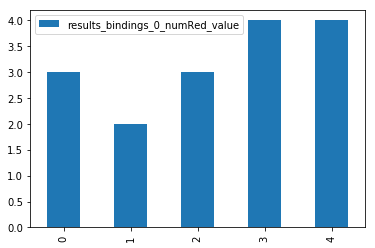

In [27]:
% matplotlib inline
df.plot(kind='bar')

In [28]:
jasper.delete(qid)